## Sistemas de recomendación
Todo el tiempo estamos reciviendo recomendaciones, en udemy netflix y otro tipo de plataformas en base a grupos que se parecen a nosotros reciviremos recomendaciones

#### Carga de datos de Movie Lense

In [1]:
import pandas as pd
import numpy as np

In [8]:
df=pd.read_csv("archivos/peliculas.csv", sep="\t", header=None)
df

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
507,13,229,4,882397650
508,298,486,3,884183063
509,235,185,4,889655435
510,62,712,4,879376178


In [9]:
df.shape

(512, 4)

In [10]:
df.columns=["UserID", "ItemID", "Rating", "TimeStamp"]

## Análisis exploratorio de los items

In [11]:
import matplotlib.pyplot as plt

(array([ 27.,   0.,  64.,   0.,   0., 136.,   0., 176.,   0., 109.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

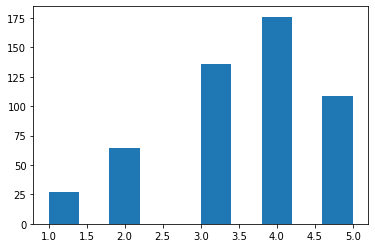

In [12]:
## ver la distribución de los datos
plt.hist(df.Rating)

(array([53., 51., 52., 53., 51., 51., 50., 50., 50., 51.]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.]),
 <BarContainer object of 10 artists>)

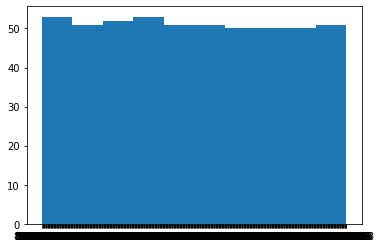

In [13]:
plt.hist(df.TimeStamp)

In [15]:
df.groupby("Rating").count()

,UserID,ItemID,TimeStamp
Rating,,,
1,27,27,27
2,64,64,64
3,136,136,136
4,176,176,176
5,109,109,109


## Representación en forma matricial

In [50]:
n_users = df.UserID.unique().shape[0]
n_items = df.ItemID.unique().shape[0]

In [65]:
df.UserID.max()

308

In [67]:
ratings = np.zeros((df.UserID.max(), df.ItemID.max()))

In [66]:
ratings.shape

(196, 364)

In [70]:
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

In [73]:
ratings.shape

(308, 1451)

In [75]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity = sparsity/(ratings.shape[0]*ratings.shape[1])
sparsity *= 100
print("Coeficiente de sparseidad: {:4.2f}%".format(sparsity))

Coeficiente de sparseidad: 0.11%


## Crear un conjunto de entrenamiento y de validación

In [83]:
from sklearn.model_selection import train_test_split

In [84]:
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.3, random_state=42)

In [85]:
ratings_train.shape

(215, 1451)

In [86]:
ratings_test.shape

(93, 1451)

In [87]:
## se ofrecerá una película si la suma ponderada que ha ofrecido el usuario es similiar
## a la súma ponderada de otros usuarios para dicho item


### Filtro colaborativo basado en usuarios

* Matriz de similaridad entre los usuarios (distancia del coseno).
* Predecir la valoración desconocida de un ítem i para un usuario activo u basandonos en la suma ponderada de todas las valoraciones del resto de usuarios para dicho ítem.
* Recomendaremos los nuevos ítems a los usuarios según lo establecido en los pasos anteriores.

In [88]:
import numpy as np
import sklearn

In [89]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_train)

In [90]:
sim_matrix

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [91]:

users_predictions = sim_matrix.dot(ratings_train) / np.array([np.abs(sim_matrix).sum(axis=1)]).T

In [92]:

users_predictions

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [93]:
from sklearn.metrics import mean_squared_error

In [94]:
##saber si la predicción fue correcta
def get_mse(preds, actuals):
    if preds.shape[0] != actuals.shape[0]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

In [95]:
get_mse(users_predictions, ratings_train)

1.3246803384723826

## Filtro colaborativo basado en los KNN
En vez de utilizar todos los miembros del dataset utilizar solo los más parecidos al individuo

In [96]:
from sklearn.neighbors import NearestNeighbors

In [97]:
k = 5

In [98]:
neighbors = NearestNeighbors(k, 'cosine')

c:\Users\Golfa\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=5, radius=cosine as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [99]:
neighbors.fit(ratings_train)

NearestNeighbors(radius='cosine')

In [100]:
top_k_distances, top_k_users = neighbors.kneighbors(ratings_train, return_distance=True)

In [101]:
top_k_distances.shape

(215, 5)

In [102]:
top_k_distances[0]

array([0.        , 6.55743852, 7.07106781, 7.07106781, 7.07106781])

In [103]:
top_k_users[0]

array([  0, 180, 106, 214,   1], dtype=int32)

In [104]:
users_predicts_k = np.zeros(ratings_train.shape)
for i in range(ratings_train.shape[0]):# para cada usuario del conjunto de entrenamiento
    users_predicts_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i]) / np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T

c:\Users\Golfa\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [105]:
users_predicts_k.shape

(215, 1451)

In [106]:
users_predicts_k

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [nan, nan, nan, ..., nan, nan, nan],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [nan, nan, nan, ..., nan, nan, nan]])

In [107]:
get_mse(users_predicts_k, ratings_train)

12.783677306555271

In [108]:
ratings_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Filtro colaborativo basado en Items

In [109]:
n_movies = ratings_train.shape[1]
n_movies

1451

In [110]:
neighbors = NearestNeighbors(n_movies, 'cosine')
neighbors.fit(ratings_train.T)
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

c:\Users\Golfa\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=1451, radius=cosine as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [113]:

item_preds = ratings_train.dot(top_k_distances) / np.array([np.abs(top_k_distances).sum(axis=1)])

In [115]:
item_preds

array([[0.        , 0.00182808, 0.00643951, ..., 0.10196109, 0.11303065,
        0.02808624],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00194995, 0.00440887, ..., 0.02906575, 0.03223194,
        0.00800999],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00146246, 0.00551108, ..., 0.145419  , 0.16233333,
        0.04032185],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [114]:
get_mse(item_preds, ratings_test)

IndexError: index 217 is out of bounds for axis 0 with size 215

## Filtrado colaborativo basado en KNN

In [116]:
k = 30
neighbors = NearestNeighbors(k, 'cosine')
neighbors.fit(ratings_train.T)
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

c:\Users\Golfa\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=30, radius=cosine as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [117]:
top_k_items[0]

array([   0, 1196,  639,  401,  648,   85,   35,   36,  178,  725,   37,
         27,   29,   34,   23,   25,   21,   40,   28,   38,   31,    8,
          5,    7,   12,   26,   15,   17,   18,   30], dtype=int32)

In [118]:
preds = np.zeros(ratings_train.T.shape)
for i in range(ratings_train.T.shape[0]):
    if(i%50==0):
        print("iter "+str(i))
    den = 1
    if (np.abs(top_k_distances[i]).sum(axis=0)>0):
        den = np.abs(top_k_distances[i]).sum(axis=0)
    preds[i, :] = top_k_distances[i].dot(ratings_train.T[top_k_items][i])/np.array([den]).T

iter 0
iter 50
iter 100
iter 150
iter 200
iter 250
iter 300
iter 350
iter 400
iter 450
iter 500
iter 550
iter 600
iter 650
iter 700
iter 750
iter 800
iter 850
iter 900
iter 950
iter 1000
iter 1050
iter 1100
iter 1150
iter 1200
iter 1250
iter 1300
iter 1350
iter 1400
iter 1450


In [119]:
get_mse(preds, ratings_train)

12.439896036719063

In [120]:
get_mse(preds, ratings_test)

14.418032786885245

In [121]:
preds.shape,ratings_train.shape,ratings_test.shape

((1451, 215), (215, 1451), (93, 1451))